# How to utilize the Processing API

The goal of this notebook is to show how the Processing API can be utilized. Discover the required steps to acquire cloud-free Sentinel-2 imagery via ClearSky Vision API. This guide includes Python code examples to show you how to effortlessly download cloudless, high-quality earth observation data. The notebook starts out with asking whether there is data in the area of interest (AOI), afterwards we estimate area and credit costs, and finally download the available imagery.

**Table of Contents:**
* Importing libraries
* Acquiring user credentials
* Functions for 'data availability'
* Requesting 'data availability'
* Functions for estimating credit cost and area
* Requesting estimated credit costs and area
* Functions for download imagery
* Downloading a single satellite image
* Visualizing acquired satellite image

You can contact info@clearsky.vision if you have any questions or issues.

## Importing necessary libraries  
We import the libraries that are necessary for this notebook.

In [1]:
from datetime import datetime, timedelta
import requests
import json
import time
from pathlib import Path
import sys
from tqdm import tqdm
import os
import shutil
import random
import string

## Acquiring user credentials

You can request API trial credentials from eo.clearsky.vision by clicking "GET API KEY" and get €125 worth of credits. The credentials will be sent to the provided email straightaway. Alternatively, you can ask for access by writing to info@clearsky.vision and get in contact with a human.

In [2]:
# Class to store user credentials
class User():
    def __init__(self, api_key):
        self.api_key = api_key
        
# Create an instance of User
credentials = User(api_key="XXXXXXXXXXXXXXXXXXXXXX")

## Defining functions for 'data availability'
If the goal is fully automated satellite data acquisition, it can be a good idea to ask whether 'todays' imagery is available or if it's delayed before download data. That way there is no surprises. It's particular useful if the AOI is large enough to cross multiple of our tiles. The API call for asking about data availability is free but still requires an API key. 

In [3]:
# Simplified Class for creating query objects for availability check
class simple_Query():
    def __init__(self, bounding_box, date):
        self.bounding_box = bounding_box
        self.date = date.split(" ")[0] + "T00:00:00Z"

# Function to check the availability of satellite imagery
def check_availability(credentials, query):
    url = "https://api.clearsky.vision/api/SatelliteImages/process/composite/available"
    
    body = {
        "Wkt": query.bounding_box,
        "Date": query.date
    }
    
    headers = {
        'Content-Type': 'application/json',
        'X-API-KEY': credentials.api_key
    }

    response = requests.post(url, headers=headers, json=body)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        if response.content:
            try:
                print(response.json())  # Attempt to print JSON response if available
            except ValueError:
                print(response.content)  # Print raw content if JSON parsing fails

## Requesting data availability information

The 'data availability' end-point returns four categories of availability:
* IntersectedActiveZones: Boolean set to true if any tile area intersecting polygon was found.
* FullyAvailable: Boolean set to true if all underlying areas intersecting polygon contain satelliteimage with requested date.
* PolygonInDataArea: Boolean set to true if polygon is in an area with data (e.g. not completely in water).
* DataAvailableForUser: Boolean set to false if data access for specified date and area has been restricted. Contact for more information.

In [4]:
# Set your parameters for checking availability
bounding_box = "POLYGON ((13.53241 57.370977, 13.53241 57.585087, 14.230042 57.585087, 14.230042 57.370977, 13.53241 57.370977))"
from_date = datetime(year=2023, month=6, day=2)  

# Initialize the Query object with these parameters
query = simple_Query(bounding_box, str(from_date))

availability = check_availability(credentials, query)

# Process and print the response
if availability is not None:
    print(f"Imagery available: {availability['Data']}")
else:
    print("Failed to check availability. Check your query parameters or network connection.")

Imagery available: {'IntersectedActiveZones': True, 'FullyAvailable': True, 'PolygonInDataArea': True, 'DataAvailableForUser': True, 'DataOnZoneDataFrequencyDate': True}


## Defining functions for estimating credit cost
The credit cost of using the Processing API is equal to area but we can still ask what the estimated cost and size is. First we setup the functions we will need to estimate area and credit costs. It requires an identical query to when downloading data.

In [5]:
# Class for creating query objects
class Query():
    def __init__(self, bounding_box, date, resolution, bands, epsg_out, filetype, pixel_selection_mode):
        self.bounding_box = bounding_box
        self.date = date.split(" ")[0] + "T00:00:00Z"
        self.resolution = resolution
        self.bands = bands
        self.epsg_out = epsg_out
        self.filetype = filetype
        self.pixel_selection_mode = pixel_selection_mode

# Function to estimate data for a single image
def request_estimate(query):
    url = "https://api.clearsky.vision/api/SatelliteImages/process/composite/estimate"
    
    # Create the payload for POST request from the provided 'query' object
    body = {
        "Wkt": query.bounding_box,
        "Date": query.date,
        "Resolution": query.resolution,
        "FileType": query.filetype,
        "Bandnames": query.bands
    }

    resp = requests.post(url, json=body)

    if resp.status_code == 200:
        return resp.json()
    else:
        print(resp.content)

## Requesting estimated credit costs and area

The end-point returns credit cost, processing time, area size and file size. This API call is free to call, thus it does not cost credits to ask for an AOI estimate. 

In [6]:
# Set your parameters
bounding_box = "POLYGON ((13.53241 57.370977, 13.53241 57.585087, 14.230042 57.585087, 14.230042 57.370977, 13.53241 57.370977))"
from_date = datetime(year=2023, month=6, day=2)  
resolution = 10  # Resolution value
bands = 'all'  # Band setting
epsg_out = 3857  # EPSG code
filetype = 'tif'  # File type
pixel_selection_mode = 'Intersect' # Pixel selection

# Initialize the Query object with these parameters
query = Query(bounding_box, str(from_date), resolution, bands, epsg_out, filetype, pixel_selection_mode)

# Request an estimate using the Query object
resp = request_estimate(query)

# Process and print the response
if resp is not None:
    print(f"Job credit cost: {resp['Data']['CreditEstimate']} credits")
    print(f"Job processing time: ~{resp['Data']['FastTimeEstimateSeconds']} to {resp['Data']['SlowTimeEstimateSeconds']} Seconds")
    
    area_km2 = resp['Data']['AreaEstimateKm2']
    print(f"Job output area: {area_km2:.2f} km2")  

    estimated_file_size = resp['Data']['FileSizeEstimateMB']
    print(f"Estimated file size: {estimated_file_size:.2f} MB")  
else:
    print("Failed to get an estimate. Check your query parameters or network connection.")


Job credit cost: 99.79 credits
Job processing time: ~80 to 128 Seconds
Job output area: 997.94 km2
Estimated file size: 195.67 MB


## Setting output folder path
Setting the 'Downloads' folder to be the imagery distination or creates it if it does not exist. 

In [7]:
# Get the user's profile directory
user_profile = os.path.expandvars("%userprofile%")

# Get the path to the user's "Downloads" folder
downloads_folder = os.path.join(user_profile, "Downloads")

# Ensure there's a forward slash at the end of the path
downloads_folder = downloads_folder.replace("\\", "/")

# Append a trailing forward slash if it's not present
if not downloads_folder.endswith('/'):
    downloads_folder += '/'

# Check if the "Downloads" folder exists, and if not, create it
if not os.path.exists(downloads_folder):
    os.makedirs(downloads_folder)

# Print the full folder path (Downloads folder)
print(f"Full folder path (Downloads): {downloads_folder}")

outpath = downloads_folder

Full folder path (Downloads): C:/Users/clear/Downloads/


## Defining functions for download imagery
We use the same query we defined under credit estimation to request satellite data. 

In [8]:
# Function to request data with the query
def request_data(query, outpath, credentials, show_progress, filename, start):
    print("Server is now processing your request, please wait")
    sys.stdout.flush()

    url = "https://api.clearsky.vision/api/SatelliteImages/process/composite"

    # Create the payload for POST request from the provided 'query' object
    body = {
        "Wkt": query.bounding_box,
        "Date": query.date,
        "Resolution": query.resolution,
        "EpsgProjection": query.epsg_out,
        "FileType": query.filetype,
        "Bandnames": query.bands,
        "PixelSelectionMode": query.pixel_selection_mode
    }

    headers = {
        'Content-Type': 'application/json',
        'X-API-KEY': credentials.api_key
    }

    out_file, processed_time = download_raw_data(url, outpath + filename, headers, body, show_progress, start)

    return out_file, processed_time

# Function to download data to machine
def download_raw_data(url, outfile, headers, body, show_progress, start):
    processed_time = None
    outfile_temp = str(outfile) + ".incomplete"
    try:
        downloaded_bytes = 0
        with requests.post(url, headers=headers, json=body, stream=True, timeout=3000) as req:
            with tqdm(unit="B", unit_scale=True, disable=not show_progress) as progress:
                chunk_size = 2 ** 20
                with open(outfile_temp, "wb") as fout:
                    for chunk in req.iter_content(chunk_size=chunk_size):
                        if chunk:
                            if processed_time is None:
                                processed_time = datetime.now()
                                print("Processing finished, time elapsed: " + str((processed_time - start).seconds) + " seconds, starting download")
                            fout.write(chunk)
                            progress.update(len(chunk))
                            downloaded_bytes += len(chunk)
        shutil.move(outfile_temp, outfile)
        if downloaded_bytes < 1000:  # something went wrong
            with open(outfile, "r") as f_in:
                lines = f_in.readlines()
            os.remove(outfile)

            print("Download failed, with response: " + lines[0])
            return None, processed_time
    except Exception as E:
        print("Download failed:", E)
        return None, processed_time
    finally:
        try:
            Path(outfile_temp).unlink()
        except OSError:
            pass

    return outfile, processed_time

## Downloading a single satellite imagery

You can more carefully choose which pixels are returned with the 'PixelSelectionMode' parameter: 
* Intersect: Include all pixels that intersect bounding box (default).
* Contained: Include all pixels fully covered by bounding box.

In [9]:
# Set download parameters
bounding_box = "POLYGON ((15.424805 56.712044, 15.424805 56.923995, 16.11969 56.923995, 16.11969 56.712044, 15.424805 56.712044))"
date = datetime(year=2023, month=6, day=2)  
resolution = 10
bands = 'all'
epsg_out = 3857
filetype = 'tif'
show_progress = True
pixel_selection_mode = 'Intersect'

# Create a query
query = Query(bounding_box, str(date), resolution, bands, epsg_out, filetype, pixel_selection_mode)

# Prepare filename based on date or other parameters
filename = str(date.date()).replace("-", "") + ".tif"  

# Start time for download
start_time = datetime.now()

# Call request_data to download the data
downloaded_file, processed_time = request_data(query, outpath, credentials, show_progress, filename, start_time)

# Check if the download was successful
if downloaded_file is not None:
    print(f"File downloaded successfully: {downloaded_file}")
else:
    print("Download failed.")

Server is now processing your request, please wait


459kB [00:00, 4.54MB/s]

Processing finished, time elapsed: 39 seconds, starting download


128MB [00:01, 99.7MB/s] 

File downloaded successfully: C:/Users/clear/Downloads/20230602.tif


## Visualizing satellite data
To be able to visualize the multi-spectral data in this notebook we need a few more imports (matplotlib and numpy) and to install rasterio. The data we have downloaded is multi-spectral, so we need to pick Red, Green and Blue bands to produce a true-color image we can showcase. 

In [10]:
pip install rasterio

Note: you may need to restart the kernel to use updated packages.


In [11]:
# importing necessary libraries
import rasterio
import numpy as np
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


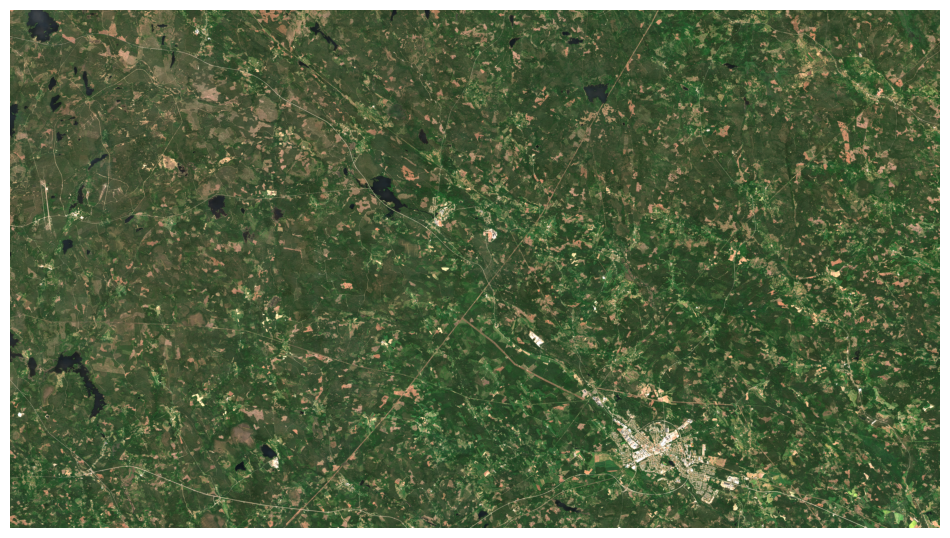

In [12]:
# Open the GeoTIFF file
with rasterio.open(downloaded_file) as src:
    # Read the specific bands you need
    blue_band = src.read(1)  # Replace 1 with the actual band index for blue
    green_band = src.read(2)  # Replace 2 with the actual band index for green
    red_band = src.read(3)  # Replace 3 with the actual band index for red

# Stack the bands to create a true-color image
true_color_image = np.dstack((red_band, green_band, blue_band))
true_color_image = true_color_image/32767*22

custom_vmin = 0  # Define your custom minimum value
custom_vmax = 1  # Define your custom maximum value

# Display the image with custom clipping and valid range
plt.figure(figsize=(12, 9))
plt.imshow(true_color_image, vmin=custom_vmin, vmax=custom_vmax)
plt.axis('off')
plt.show()

That is it for now. If you have any request about new guides or features, let us know! 